---
# Example of classification using two gaussian distributions.
---

In this example, we generate a global probability distribution function (PDF) that is the sum of two gaussian PDF. 
Each one is weighted with its <i>a priori</i> class probability $P(C_{i})$:


<blockquote>  $P(\bf{x}) = P(\bf{x}|C_{1}) P(C_{1}) + P(\bf{x}|C_{2}) P(C_{2})$ </blockquote>



Our goal is to locate the influence zone of each class i. This corresponds to the zone where 

<blockquote> $P(\bf{x}|C_{i}) P(C_{i}) > P(\bf{x}|C_{j}) P(C_{j})$ </blockquote>

<br><br>
The matrix-form equation for the 2-D gausian PDF is: 

<blockquote>  $P(\bf{x}) = \frac{1}{2\pi |\Sigma|^{0.5}} \exp{[-\frac{1}{2}(\bf{x}-\bf{\mu})^\top \Sigma^{-1} (\bf{x}-\bf{\mu})]}$  </blockquote>

with 

<blockquote>  The observation:   $\bf{x}=[x_{1} x_{2}]^\top$ </blockquote> 

<blockquote>  The origin:   $\bf{\mu} = [\mu_{1} \mu_{2}]^\top$  </blockquote> 

<blockquote>  The covariance matrix: $\Sigma = \begin{pmatrix} \sigma_{x_{1}}^2 & \sigma_{x_{1,2}} \\ \sigma_{x_{1,2}} & \sigma_{x_{2}}^2 \end{pmatrix}$ </blockquote>




In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from skimage.transform import resize

import seaborn as sns; sns.set()
np.random.seed(42)

## Parameters of the two gaussians PDF. 

In this example, the covariance matrices $\Sigma$ are not explicitely provided and must be computed. 
We use an easy method to design $\Sigma$ with some desired characteristics. It becomes handy for visualization purpose.

First, we generate the covariance matrix for an uncorrelated PDF; its principal axes are oriented along the 
$x_{1}$ and $x_{2}$ axes. The values of $\sigma_{1}$ and $\sigma_{2}$ can be adjusted to get the right ellipsoid shape. 

<blockquote>  $\Sigma_{PA} = \begin{pmatrix} \sigma_{1}^2 & 0 \\ 0 & \sigma_{2}^2 \end{pmatrix}$ </blockquote>

Next, we must rotate the ellipsoid over an angle $\theta$. Using the rotation matrix

<blockquote>  $R = \begin{pmatrix} \cos{\theta}  & -\sin{\theta} \\ \sin{\theta} & \cos{\theta} \end{pmatrix}$ </blockquote>

the covariance matrix we are looking for becomes 

<blockquote>  $\Sigma = R \Sigma_{PA} R^\top $ </blockquote>



<br><br>
N.B. For ease of reading, we use below the variables x and y instead of x1 and x2. The final results are shown with x1 and x2.

In [2]:
# Origins of the PDF
Mu = np.zeros((2,2))
Mu[0,:] = [6., 3.]
Mu[1,:] = [6., 7.]

# Standard deviations along the x1 and x2 directions (or x and y)
sigma = np.zeros((2,2))
sigma[0,:] = [2., 0.7]
sigma[1,:] = [1.2, 0.7]

# Rotation angles for the principal axis
theta = np.array([-30., 0.]) 

# A priori class probabilities
prob_C = np.array([0.5, 0.5]) 


Compute the covariance matrix $\Sigma$

In [3]:
Sigma = np.zeros((2,2,2))
for i in range(2):
    angle = np.radians(theta[i])
    c, s = np.cos(angle), np.sin(angle)

    # Rotation matrix
    R = np.array(((c, -s), (s, c)))        

    # Covariance matrix for a PDF with its principal axes oriented along the x and y directions
    sig = np.array([[sigma[i,0]**2, 0.],[0., sigma[i,1]**2]])

    # Covariance matrix after rotation
    Sigma[:,:,i] = R.dot( sig.dot(R.T) )  


## Global PDF computation
Generate a spatial grid where the PDF will be evaluated locally.

In [4]:
x_min, x_max = 0., 10.
y_min, y_max = 0., 10.
nx, ny = 300, 300
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(x,y) 
pos = np.dstack((xx, yy)) 
        

Compute the global PDF

In [5]:
# Weighted PDF
model = multivariate_normal(Mu[0,:], Sigma[:,:,0]) 
pdf0 = prob_C[0]*model.pdf(pos)

model = multivariate_normal(Mu[1,:], Sigma[:,:,1]) 
pdf1 = prob_C[1]*model.pdf(pos)

# Global PDF 
pdf = pdf0 + pdf1

# Define a mask to identify the influence zone of each class: Mask=False for class 0 and Mask=True for class 1
mask = pdf1 > pdf0


## Display the global PDF 

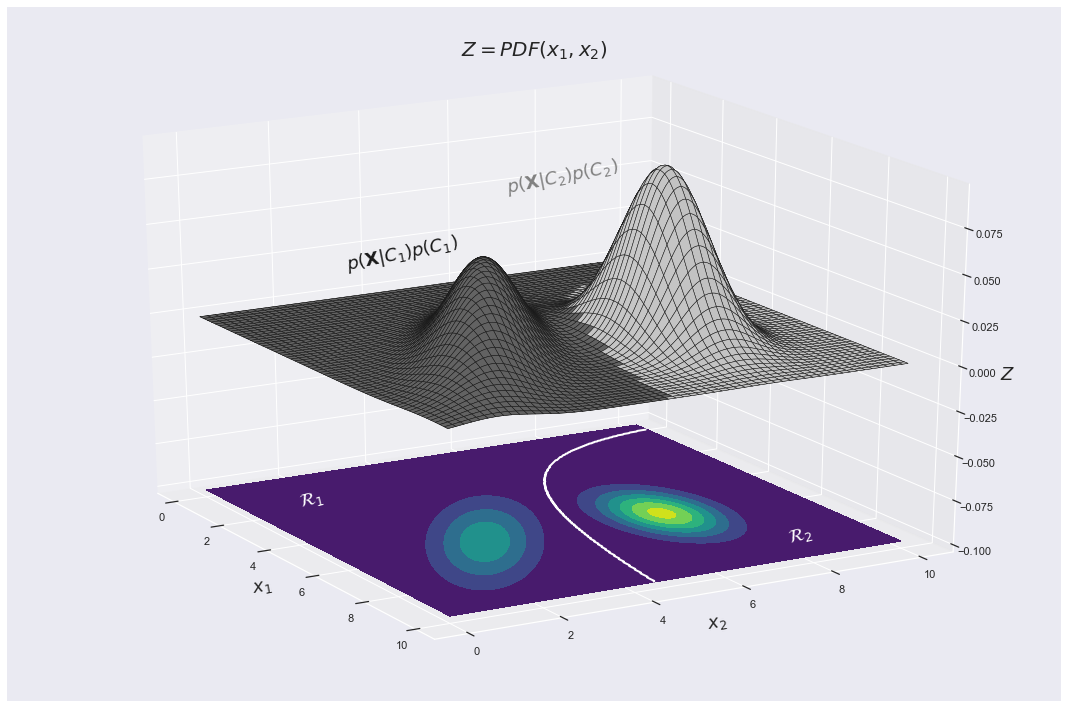

In [7]:
z_offset = -0.1
view=[22., -30.]


fig = plt.figure(figsize = (15,10))
ax = fig.gca(projection='3d')


# ---------Generate overlying 3-D surface with colors indicating the influence zone of each class
rstride, cstride = 5, 5

s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='gray', edgecolors='k')       
a1 = s.__dict__['_original_facecolor']
b1 = s.__dict__['_facecolors']
c1 = s.__dict__['_facecolors3d']

s = ax.plot_surface(xx, yy, pdf, rstride=rstride, cstride=cstride, linewidth=.5, antialiased=True, color='w', edgecolors='k')
a2 = s.__dict__['_original_facecolor']
b2 = s.__dict__['_facecolors']
c2 = s.__dict__['_facecolors3d']

Lx = int(nx/rstride)
Ly = int(ny/cstride)

mask2 = resize(mask, (Lx,Ly), order=0)
indx = np.argwhere(mask2)
idx = indx[:,0]*Lx + indx[:,1]

a = a1
b = b1
c = c1
for i in idx:
    a[i,:] = a2[i,:]
    b[i,:] = b2[i,:]
    c[i,:] = c2[i,:]
    
s.__dict__['_original_facecolor'] = a
s.__dict__['_facecolors'] = b
s.__dict__['_facecolors3d'] = c


# --------- Generate underlying contours with borders between each class
cset = ax.contourf(xx, yy, pdf, zdir='z', offset=z_offset, cmap='viridis')
ax.contour(xx, yy, mask, [0.5], offset=z_offset, linewidths=2., colors='white') 

# N.B. For convenience, we use classes 1 and 2 instead of classes 0 and 1 in the figure
ax.text(2, 1, z_offset,'$\mathcal{R}_{1}$', zdir='y', color='w',fontsize=18)        
ax.text(9, 8, z_offset,'$\mathcal{R}_{2}$', zdir='y', color='w',fontsize=18)    
ax.text(6, 2.5, 0.05, '$p(\mathbf{X}|C_{1})p(C_{1})$', zdir='y', horizontalalignment='right', verticalalignment='bottom', color='k',fontsize=18)    
ax.text(6, 6., 0.08, '$p(\mathbf{X}|C_{2})p(C_{2})$', zdir='y', horizontalalignment='right', verticalalignment='bottom', color='gray',fontsize=18)    

ax.set_zlim(z_offset, np.max(pdf))
ax.view_init(view[0], view[1])


ax.set_ylabel('$x_{2}$', fontsize=18)
ax.xaxis.set_rotate_label(False)  
ax.set_xlabel('$x_{1}$', rotation=10, fontsize=18)

ax.set_zlabel('$Z$', rotation=0, fontsize=18)
ax.set_title('$Z = PDF(x_{1},x_{2})$', fontsize=20)
    
fig.tight_layout()

plt.savefig('Influence_zones_in_gaussian_PDF_classification.png', format='png')


plt.show()


